In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json

In [3]:
df1 = pd.read_csv('shop_open.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df_input = df1[['High Change', 'Low Change', 'Vix ewm', 'Vix Close', 'CAD Close', 'Spread', 'Spread Change', 'Volume Diff', 'Vol change', 'Return ewm', 'Vix return', 'Crm return', 'Tsx return', 'Return', 'Chaikin']]
df_input

,High Change,Low Change,Vix ewm,Vix Close,CAD Close,Spread,Spread Change,Volume Diff,Vol change,Return ewm,Vix return,Crm return,Tsx return,Return,Chaikin
Date,,,,,,,,,,,,,,,
2015-05-26,0.005871,0.028571,0.102176,14.060000,1.23193,1.689999,-0.315790,-21000.0,-0.178268,0.021792,0.159110,-0.019197,-0.008994,-0.009125,-48625.000000
2015-05-27,0.012470,-0.065833,-0.003400,13.270000,1.24244,4.529999,1.680475,38900.0,0.401860,-0.036434,-0.056188,0.005165,0.003967,-0.065547,-4862.500000
2015-05-28,-0.093291,-0.014570,0.000876,13.310000,1.24540,1.459999,-0.677704,-97300.0,-0.717023,-0.021807,0.003014,-0.017174,-0.000232,-0.014493,-51081.250000
2015-05-29,-0.010116,0.006337,0.026839,13.840000,1.24251,0.900002,-0.383560,-15600.0,-0.406250,-0.016681,0.039820,0.000963,-0.006149,-0.014118,-33340.625000
2015-06-01,0.003796,0.002399,0.015208,13.970000,1.24561,0.950001,0.055555,-11400.0,-0.500000,0.008760,0.009393,0.004811,0.003996,0.021480,-22370.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13,-0.008116,0.001041,-0.032076,22.209999,1.27077,35.949951,-0.280857,-3400.0,-0.027222,0.006885,-0.048007,0.012342,-0.002841,0.007206,-17203.072687
2021-01-14,0.022090,-0.007460,0.020525,23.250000,1.26981,80.789917,1.247289,109900.0,0.904527,-0.012968,0.046826,-0.011825,0.001305,-0.022894,46348.463656
2021-01-15,-0.027605,-0.009646,0.038096,24.340000,1.26477,51.989990,-0.356479,-132400.0,-0.572169,-0.003306,0.046882,-0.011410,-0.002734,0.001525,-43025.768172


In [4]:
y = df1[["Pos"]]
y.head()

,Pos
Date,
2015-05-26,0
2015-05-27,0
2015-05-28,0
2015-05-29,1
2015-06-01,0


In [5]:
file_path = Path("shop_model_posneg.json")
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

file_path = "shop_weights_posneg.h5"
loaded_model.load_weights(file_path)

In [6]:
split = int(0.7 * len(df1))

df = df1[split:]


df_test = df_input[split:]
df_test.shape

(418, 15)

In [7]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_input, y, test_size=0.3, random_state=42)

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()


x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)


x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(df_test)

enc = OneHotEncoder()
enc.fit(y_train)

encoded_y_train = enc.transform(y_train).toarray()
encoded_y_test = enc.transform(y_test).toarray()

In [8]:
predicted = loaded_model.predict(x_test)
predicted = enc.inverse_transform(predicted).flatten().tolist()
df["tomo prediction"] = predicted

C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
from sklearn.metrics import classification_report
print(classification_report(df.Pos, df["tomo prediction"]))

              precision    recall  f1-score   support

           0       0.56      0.16      0.25       197
           1       0.54      0.89      0.67       221

    accuracy                           0.55       418
   macro avg       0.55      0.52      0.46       418
weighted avg       0.55      0.55      0.47       418



In [10]:
from sklearn.metrics import classification_report
print(classification_report(df.Pos, df["tomo prediction"]))

              precision    recall  f1-score   support

           0       0.56      0.16      0.25       197
           1       0.54      0.89      0.67       221

    accuracy                           0.55       418
   macro avg       0.55      0.52      0.46       418
weighted avg       0.55      0.55      0.47       418



In [11]:
df = df[["Open", "tomo prediction"]]
df["Pos"] = df1["Pos"]
df["prediction"] = df["tomo prediction"].shift(1)
df["last"] = df["prediction"].shift(1)
df = df.dropna()
back_csv_data = df.to_csv('Shopify_backtest.csv', index = True) 

In [15]:
import math
capital = float(100)
pos = float(1)
neg = float(0)

def Backtest(capital, split, year):
    initial_capital = capital
    df1 = df.loc[year:]
    shares = math.floor((initial_capital/df1.iat[0,0]) * split)
    hold_shares = math.floor(initial_capital/df1.iat[0,0]) - shares
    capital = capital - ((df1.iat[0,0] * shares) + (df1.iat[0,0] * hold_shares))
    bnh_shares = math.floor(initial_capital/df1.iat[0,0])
    newshares = shares
    port = shares
    sells = 0
    buys = shares + hold_shares
    tradelist = []
        
    if split > 1:
        return "Split Invalid, Please Choose a number between 0 and 1 to determine how the % of your portfolio to be actively traded."
    
    elif year < "2017":
        return "We can only backtest back to 2017"
    
    elif capital < 0:
        return "Not Enough Starting Capital"
    
    else:
        for i, row in df1.iterrows():
            if row['prediction'] == 1.0 and row['last'] == 0.0:
                if capital > (row['Open'] * shares):
                    capital = capital - (row['Open'] * shares)
                    port = port + shares
                    buys = buys + shares
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                else: 
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
        
            elif row['prediction'] == 0.0 and row['last'] == 1.0:
                if port >= shares:
                    capital = capital + (row['Open'] * shares)
                    port = port - shares
                    sells = sells + shares
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                elif port == 0:
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                else:
                    while port < newshares:
                        if port < newshares:
                            newshares = newshares - 1
                        elif port >= newshares:
                            capital = capital + (row['Open'] * newshares)
                            port = port - newshares
                            sells = sells + newshares
                            newshares = shares
                            tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                            break
            else:
                tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
            
        tport = round(capital + (port * df1.iat[-1,0]) + (hold_shares * df1.iat[-1,0]),2)
                
        df1["port"] = tradelist
        df1["Open2"] = df1["Open"] * bnh_shares
        
        df1.plot(y=["port", "Open2"], kind="line")
        plt.legend(["Our Strategy", "Buy and Hold Strategy"])
                
        treturn = round(((tport - initial_capital)/initial_capital) * 100, 2)
        shop = round(((df1.iat[-1,0] - df1.iat[0,0])/df1.iat[0,0]) * 100, 2)
        bnh_leftover = initial_capital - (df1.iat[0,0] * bnh_shares)
        bnh = round(((df1.iat[-1,0] * bnh_shares) + bnh_leftover),2)
        bnh_per = round(((bnh - (initial_capital))/initial_capital)*100, 2)
        print(f"Your Total Return is {treturn}%")
        print("")
        print(f"Total Portfolio Value is ${tport}")
        print("")
        print(f"Portfolio Breakdown")
        print(f"Avail. Funds: ${round(capital,2)}")
        print(f"Shares Value: ${round((tport-capital),2)}")
        print("")
        print(f"Shopifys return is {shop}%")
        print("-------------------------------------------")
        print(f"                        Return     Total")
        print(f"Our Strategy:            {treturn}%      {tport}")
        print(f"Buy and Hold Strategy:   {bnh_per}%      {bnh}")
        print(f"")
        print(f"-------------------------------------------")
        print(f"Buy Orders: {buys}")
        print(f"Sell Orders: {sells}")
        print(f"Total Trades: {buys+sells}")

C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Your Total Return is 136.83%

Total Portfolio Value is $23682.84

Portfolio Breakdown
Avail. Funds: $8731.24
Shares Value: $14951.6

Shopifys return is 184.89%
-------------------------------------------
                        Return     Total
Our Strategy:            136.83%      23682.84
Buy and Hold Strategy:   184.36%      28436.46

-------------------------------------------
Buy Orders: 127
Sell Orders: 117
Total Trades: 244


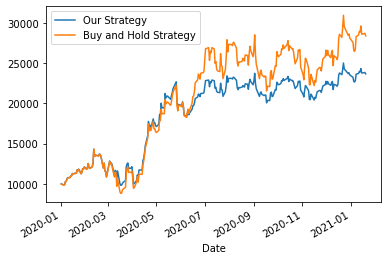

In [16]:
Backtest(10000,.5, "2020")

In [14]:
df2 = df["2021":]
df2

,Open,tomo prediction,Pos,prediction,last
Date,,,,,
2021-01-04,1452.500000,1,1,1.0,1.0
2021-01-05,1400.989990,1,0,1.0,1.0
2021-01-06,1393.250000,1,1,1.0,1.0
2021-01-07,1410.410034,1,1,1.0,1.0
2021-01-08,1491.219971,1,0,1.0,1.0
2021-01-11,1500.010010,1,1,1.0,1.0
2021-01-12,1524.430054,1,1,1.0,1.0
2021-01-13,1520.089966,0,0,1.0,1.0
2021-01-14,1560.209961,1,1,0.0,1.0
